In [11]:
%pylab inline

from __future__ import (division, print_function)

import os
import sys
import copy
import fnmatch
import warnings

import numpy as np
import scipy
from scipy.interpolate import interp1d
import cPickle as pickle

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar

# AstroML
from astroML.plotting import hist

# Matplotlib related
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator
# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 2.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 2.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 2.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 2.5

# Personal
import hscUtils as hUtil
import galSBP

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [12]:
# Absolute magnitude of sun in HSC filters

# Actuall borrowed from DES filters
# Values from magsun.data in FSPS
amag_sun_des_g = 5.08
amag_sun_des_r = 4.62
amag_sun_des_i = 4.52
amag_sun_des_z = 4.52
amag_sun_des_y = 4.51

# Based on http://www.baryons.org/ezgal/filters.php
amag_sun_ukiss_y = 4.515

# Extinction correction factor for HSC 
## A\_lambda = Coeff * E(B-V) 

a_hsc_g = 3.233
a_hsc_r = 2.291 
a_hsc_i = 1.635
a_hsc_z = 1.261
a_hsc_y = 1.076

In [17]:
# Location of the cutouts 

import platform 

if 'Linux' in platform.platform():
    """ On Astro2 / For Linux """
    machine = 'w520'
    baseDir = '/media/hs/Astro2/hsc/master'
elif 'Darwin' in platform.platform():
    machine = 'mbp13'
    """ On Astro3 / For MacOS"""
    baseDir = '/Users/songhuang/astro3/hscs' 
else: 
    raise Exception("## Unknown location for HSC data!")

# The two current datasets 
redBCG = os.path.join(baseDir, 'redmapper')
if not os.path.exists(redBCG): 
    raise Exception("## Can not find location for redBCG data")
nonBCG = os.path.join(baseDir, 'nonbcg')
if not os.path.exists(nonBCG): 
    raise Exception("## Can not find location for nonBCG data")
    
# Summary tables: 
redBCG_sum = os.path.join(redBCG, 'redBCG_new.fits')
nonBCG_sum = os.path.join(nonBCG, 'nonBCG_new.fits')

# Functions to Deal with Profiles

In [14]:
def findProfile(pattern, loc, verbose=False):
    """
    Find the prefix of the ellipse profiles. 
    
    Parameters: 
    """
    result = []
    for root, dirs, files in os.walk(loc):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    if verbose: 
        print("### %d files found !" % len(result))
    
    return result

In [15]:
def readProfile(ellFile):
    """ Load the pickle format 1-D profile. """
    if os.path.isfile(ellFile):
        return pickle.load(open(ellFile, 'rb'))
    else:
        warnings.warn("!!! Can not find the Ellipse Output at %s" % 
                      ellFile )
        return None

In [41]:
def getEllipProfile(galid, base, filter='HSC-I', rerun='default', 
                    prefix='redBCG', suffix=None, stage='3', 
                    verbose=False):
    """
    Find and load the Ellipse output.
    
    Parameters: 
    """
    galid = str(galid).strip()
    if suffix is None: 
        suffix = '_'
    else: 
        suffix = '_' + suffix + '_'
    
    location = os.path.join(base, galid, filter, rerun)
    ellFile = (prefix + '_' + str(galid) + '_' + filter + 
               '_full_img_ellip_' + rerun + 
               suffix + stage + '.pkl')
    ellFile = os.path.join(location, ellFile)
    
    if not os.path.isfile(ellFile): 
        if verbose:
            warnings.warn('!!! Can not find the Ellipse profile ! %s' % 
                          ellFile)
        return None
    else: 
        ellProf = readProfile(ellFile)
        return ellProf

# Useful Functions

In [29]:
def getExtinction(ra, dec, a_lambda=None):
    """
    Estimate the Galactic extinction for HSC filters
    
    Parameters: 
        ra, dec : The input coordinates can be arrays 
    """
    """ First try mwdust from Jo Bovy """
    try: 
        import mwdust
        sfd= mwdust.SFD(sf10=True)
        
        from astropy.coordinates import SkyCoord
        coords = SkyCoord(ra, dec, frame='icrs', unit='deg')
        galactic = coords.galactic 
        l, b = galactic.l, galactic.b 
        ebv = sfd(l, b, 0)
    except ImportError: 
        try: 
            """ Then try sncosmo """
            from sncosmo import SFD98Map 
            dustDir = os.environ.get('DUST_DIR')
            if (not os.path.isfile(os.path.join(dustDir, 
                'SFD_dust_4096_ngp.fits'))) or (
                not os.path.isfile(os.path.join(dustDir, 
                'SFD_dust_4096_sgp.fits'))): 
                print('# DUST_DIR : %s' % dustDir)
                raise Exception("# Can not find the SFD dust map!")
            else: 
                sfd = SFD98Map(dustDir)
                ebv = sfd.get_ebv((ra, dec))
        except ImportError: 
            raise Exception("# Both mwdust and sncosmo are not available")
    
    if a_lambda is not None: 
        return (ebv * a_lambda)
    else: 
        return ebv

In [54]:
def getDimming(z1, z0=0.1): 
    """
    Get the surface brightness dimming effect.
    
    Parameters: 
        z1: Observed redshift 
        z0: Reference redshift 
            Default = 0.1
    """
    return (3.0 * np.log10((1.0 + z1) / (1.0 + z0)))

In [55]:
def normProf(sma, sbp, minSma, maxSma): 
    """
    Naive method to normalize the profile. 
    
    Parameters: 
        sbp    : Array for surface brightness profile 
        sma    : Radius range 
        minSma : Minimum SMA
        maxSma   Maximum SMA
    """
    offset = np.nanmedian(sbp[(sma >= minSma) & 
                              (sma <= maxSma)])
    return (sbp-offset)

In [56]:
def pixKpc(redshift, pix=0.168, show=True, npix=1.0):
    """
    Get the corresponding Kpc size of a pixel.  
    
    Parameters: 
    """
    pixKpc = pix * npix * hUtil.cosmoScale(redshift)

    if show:
        print("# %d pixel(s) = %6.3f Kpc" % (npix, pixKpc))
        
    return pixKpc

In [57]:
def logAdd(para1, para2):
    """ Useful for adding magnitudes. """
    return np.log10((10.0 ** np.asarray(para1)) + 
                    (10.0 ** np.asarray(para2)))

In [80]:
def errAdd(err1, err2):
    """ Add error quadral... """
    return np.sqrt((err1 ** 2.0) + 
                   (err2 ** 2.0))

In [154]:
def getLumimosity(mag, redshift, extinction=None, 
                  amag_sun=None):
    """
    Get the absolute magnitude or luminosity 
    """
    distmod = hUtil.cosmoDistMod(redshift)
    absMag = (mag - distmod)
    if extinction is not None: 
        absMag -= extinction 
    if amag_sun is not None: 
        absMag = ((amag_sun - absMag) / 2.5)
    
    return absMag

In [76]:
def correctProf(ellProf, redshift, extinction=0.0, zp=27.0, 
                amag_sun=None, dimming=True, corCurve=True,
                verbose=False, m2l=None, z0=0.1):
    """
    Photometric correction of the Ellipse profile. 
    
    Parameters: 
    """
    
    """ Get physical pixel scale and distant module """
    scale = hUtil.cosmoScale(redshift)
    distmod = hUtil.cosmoDistMod(redshift)
    if dimming:
        dim = getDimming(redshift, z0)
    else: 
        dim = 0.0
    if verbose: 
        print("### REDSHIFT  : %7.4f" % redshift)
        print("### PIX SCALE : %7.4f kpc/arcsec" % scale)
        print("### DIST_MOD  : %7.4f mag" % distmod)
        print("### DIMMING   : %7.4f mag" % dim)
    
    """ Convert unit of major axis radius to Kpc """
    sma_kpc = ellProf['sma_asec'] * scale
    
    if not corCurve:
        abs_mag = (-2.5 * np.log10(ellProf['growth_ori']) + 
                   zp - extinction - distmod)
    else:
        abs_mag = (-2.5 * np.log10(ellProf['growth_cor']) + 
                   zp - extinction - distmod)
    
    """ Extinction and/or Dimming corrected SBP """
    sbp_cor = (ellProf['sbp'] - extinction + dim)
    sbp_cor_upp = (ellProf['sbp_upp'] - extinction + dim)
    sbp_err = (sbp_cor_upp - sbp_cor)

    """ 
    If absolute magnitude of the Sun is provided, 
    Convert the SBP into physical unit of (L_sun/kpc**2)
    """
    if amag_sun is not None: 
        abs_sbp = ((amag_sun + 21.572 - sbp_cor)/2.5 + 6.0)
        abs_sbp_low = ((amag_sun + 21.572 - sbp_cor_upp)/2.5 + 6.0)
        err_sbp = (abs_sbp - abs_sbp_low)
        """
        Convert the absolute magnitude into log(L*/L_sun)
        """
        abs_mag = ((amag_sun - abs_mag) / 2.5)
        """ 
        If M/L ratio is provided, furthur convert it into 
        surface stellar mass density profile
        """
        if m2l is not None: 
            abs_sbp += np.log10(m2l)
            abs_mag += np.log10(m2l)
    else:
        abs_sbp = sbp_cor
        err_sbp = sbp_err

    return sma_kpc, abs_sbp, abs_mag, err_sbp

In [133]:
def sbpExtract(loc, galID, redshift, filter, 
               rerun, prefix, stage,
               zp=27.0, extinction=0.0, 
               amag_sun=None, m2l=None):
    """
    Return important SBP information. 
    
    Parameters: 
    """
    prof = getEllipProfile(galID, loc, filter=filter, 
                           rerun=rerun, prefix=prefix, 
                           stage=stage)
    if prof is not None:
        ell = correctProf(prof, redshift, 
                          extinction=extinction, 
                          zp=zp, amag_sun=amag_sun, 
                          dimming=True, corCurve=True,
                          verbose=False, m2l=m2l)
        return ell
    else: 
        return None

In [134]:
def sbpCollect(loc, galID, redshift, prefix='redBCG', 
               a_g=0.0, a_r=0.0, a_i=0.0, 
               a_z=0.0, a_y=0.0, 
               m2l_g=None, m2l_r=None, m2l_i=None, 
               m2l_z=None, m2l_y=None, 
               verbose=False, save=True):
    """
    Collect profiles from the cutout folder. 
    
    Just a world-around...
    """
    """ Location and Table name """
    sumDir = os.path.join(loc, 'sum')
    sumTab = str(galID) + '_sbp_sum.fits'
    if not os.path.exists(loc): 
        os.mkdir(sumDir, exist_ok=True)
    sumTable = os.path.join(sumDir, sumTab)
        
    """ The basic reference model """
    refEllI = sbpExtract(loc, galID, redshift, 'HSC-I',
                         'default', prefix, '3', 
                          extinction=a_i, m2l=m2l_i, 
                          amag_sun=amag_sun_des_i)
    if refEllI is not None:
        """ Reference profile in I-band """
        rad, muI1, lumI1, errI1 = refEllI
        """ Create a NaN array """
        empty = copy.deepcopy(rad)
        empty[:] = np.nan
        
        """ I largeR1 """
        ellI2 = sbpExtract(loc, galID, redshift, 
                           'HSC-I', 'largeR1', prefix, '4', m2l=m2l_i,
                            extinction=a_i, amag_sun=amag_sun_des_i)
        if ellI2 is not None: 
            r, muI2, lumI2, errI2 = ellI2
        else: 
            muI2, lumI2, errI2 = empty, empty, empty
            warnings.warn('### Can not find the largeR1 for I-band!')
            
        """ I smallR1 """
        ellI3 = sbpExtract(loc, galID, redshift, 
                           'HSC-I', 'smallR1', prefix, '4', m2l=m2l_i,
                            extinction=a_i, amag_sun=amag_sun_des_i)
        if ellI3 is not None: 
            r, muI3, lumI3, errI3 = ellI3
        else: 
            muI3, lumI3, errI3 = empty, empty, empty
            warnings.warn('### Can not find the smallR1 for I-band!')

        """ G default """
        ellG1 = sbpExtract(loc, galID, redshift, 
                           'HSC-G', 'default', prefix, '4', m2l=m2l_g,
                            extinction=a_g, amag_sun=amag_sun_des_g)
        if ellG1 is not None: 
            r, muG1, lumG1, errG1 = ellG1
        else: 
            muG1, lumG1, errG1 = empty, empty, empty
            warnings.warn('### Can not find the default for G-band!')

        """ R default """
        ellR1 = sbpExtract(loc, galID, redshift, 
                           'HSC-R', 'default', prefix, '4', m2l=m2l_r,
                            extinction=a_r, amag_sun=amag_sun_des_r)
        if ellR1 is not None: 
            r, muR1, lumR1, errR1 = ellR1
        else: 
            muR1, lumR1, errR1 = empty, empty, empty
            warnings.warn('### Can not find the default for R-band!')
  
        """ Z default """
        ellZ1 = sbpExtract(loc, galID, redshift, 
                           'HSC-Z', 'default', prefix, '4', m2l=m2l_z, 
                            extinction=a_z, amag_sun=amag_sun_des_z)
        if ellZ1 is not None: 
            r, muZ1, lumZ1, errZ1 = ellZ1
        else: 
            muZ1, lumZ1, errZ1 = empty, empty, empty
            warnings.warn('### Can not find the default for Z-band!')

        """ Y default """
        ellY1 = sbpExtract(loc, galID, redshift, 
                           'HSC-Y', 'default', prefix, '4', m2l=m2l_y, 
                            extinction=a_y, amag_sun=amag_sun_des_y)
        if ellY1 is not None: 
            r, muY1, lumY1, errY1 = ellY1
        else: 
            muY1, lumY1, errY1 = empty, empty, empty
            warnings.warn('### Can not find the default for Y-band!')
        
        """ Save the summary table """
        sbpTable = Table([rad, muI1, lumI1, errI1, 
                          muI2, lumI2, errI2, 
                          muI3, lumI3, errI3, 
                          muG1, lumG1, errG1, 
                          muR1, lumR1, errR1, 
                          muZ1, lumZ1, errZ1,
                          muY1, lumY1, errY1], 
                         names=('rKpc', 'muI1', 'lumI1', 'errI1', 
                                'muI2', 'lumI2', 'errI2', 
                                'muI3', 'lumI3', 'errI3', 
                                'muG1', 'lumG1', 'errG1', 
                                'muR1', 'lumR1', 'errR1', 
                                'muZ1', 'lumZ1', 'errZ1', 
                                'muY1', 'lumY1', 'errY1'), 
                         meta={'location': loc, 
                               'galID': galID, 
                               'redshift': redshift})
        if save: 
            sbpTable.write(sumTable, format='fits', 
                           overwrite=True)
        return sbpTable
    else:
        rad, muI1, lumI1, errI1 = None, None, None, None
        warnings.warn('### Model is not available at %s for %s' % 
                      (loc, str(galID)))
        return None

# Example

In [92]:
expID = 127 
expRed = 0.185
prefix = 'redBCG'

In [108]:
tab = sbpCollect(redBCG, expID, expRed, prefix='redBCG', save=True)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log10


In [109]:
tab

rKpc,muI1,lumI1,errI1,muI2,lumI2,errI2,muI3,lumI3,errI3,muG1,lumG1,errG1,muR1,lumR1,errR1,muZ1,lumZ1,errZ1,muY1,lumY1,errY1
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,9.08618366286,-inf,nan,9.08618366286,-inf,nan,9.08618366286,-inf,nan,8.49912050035,-inf,nan,8.79752699049,-inf,nan,9.14808191897,-inf,nan,9.20747182599,-inf,nan
0.272438321346,9.0671665467,-inf,0.00315299512274,9.0671665467,-inf,0.00315299512274,9.0671665467,-inf,0.00315299512274,8.48642670283,-inf,0.00183378043267,8.7843254727,-inf,0.00183030206241,9.13381520123,-inf,0.00248232019061,9.19262766096,-inf,0.00234944308098
0.305130884052,9.06486826181,8.07662000013,0.00353705279248,9.06486826181,8.07660677047,0.00353705279248,9.06486826181,8.07661356756,0.00353705279248,8.48491218614,7.49675121621,0.00205531787782,8.78275026739,7.79452326136,0.00205682914452,9.13208223242,8.14385224267,0.00278330408127,9.19084425023,8.20266141516,0.00263594914502
0.341746600684,9.06229098522,8.42821932082,0.00396829335434,9.06229098522,8.42820604747,0.00396829335434,9.06229098522,8.428212867,0.00396829335434,8.48321918095,7.84884160768,0.00230323923901,8.78098935128,8.14657579661,0.00231168115816,9.13013644061,8.49580211671,0.00312089596234,9.18884701501,8.55458284875,0.00295777369457
0.382756224403,9.05939804612,8.65649622237,0.00445363837782,9.05939804612,8.65648289833,0.00445363837782,9.05939804612,8.65648974391,0.00445363837782,8.48132504613,8.07768830013,0.00258159176677,8.7790193503,8.37537889565,0.00260017689495,9.12794932428,8.72448267734,0.00350035858709,9.18660865159,8.78323321288,0.00332010117137
0.42868692704,9.05615271303,8.83518545258,0.00499900080624,9.05615271303,8.83517206993,0.00499900080624,9.05615271303,8.83517894562,0.00499900080624,8.47920853385,8.25703684652,0.00289374956177,8.77681776733,8.55467730119,0.00292537546416,9.12549191555,8.90363483312,0.00392657233723,9.18410213164,8.96235413911,0.0037274845622
0.480129364612,9.05250892257,8.98734738593,0.00561302182195,9.05250892257,8.98733393564,0.00561302182195,9.05250892257,8.98734084608,0.00561302182195,8.47684223196,8.40996003171,0.00324411108269,8.77435671658,8.70754315938,0.00329349086754,9.12272776491,9.05632591258,0.00440600873151,9.18129340364,9.11501397022,0.00418615142626
0.537744795564,9.04841946612,9.12320726032,0.00630406801137,9.04841946612,9.12319373213,0.00630406801137,9.04841946612,9.12320068259,0.00630406801137,8.47420015825,8.54669711776,0.00363687613561,8.77160829793,8.84421473655,0.00370985774764,9.11961931136,9.19278850767,0.00494487238563,9.17814820117,9.25144675453,0.00470270411093
0.602274044486,9.04339406518,9.24806571209,0.00705972533925,9.04339406518,9.24805209096,0.00705972533925,9.04339406518,9.24805908917,0.00705972533925,8.47099463247,8.67260871244,0.00406161288678,8.76826329033,8.97004656371,0.00416488886391,9.11575846023,9.31834859259,0.00553576921688,9.17426307472,9.37698058184,0.00526922907802


In [68]:
# Find certain profile 
# Reference profile in I-band 
expProfI = getEllipProfile(expID, redBCG, filter='HSC-I', 
                           rerun='default', prefix='redBCG', 
                           stage='3')
# G-band force model 
expProfG = getEllipProfile(expID, redBCG, filter='HSC-G', 
                           rerun='default', prefix='redBCG',
                           stage='4')

In [69]:
expProfG

sma,intens,int_err,pix_var,rms,ell,ell_err,pa,pa_err,x0,x0_err,y0,y0_err,grad,grad_err,grad_r_err,rsma,mag,mag_lerr,mag_uerr,tflux_e,tflux_c,tmag_e,tmag_c,npix_e,npix_c,a3,a3_err,b3,b3_err,a4,a4_err,b4,b4_err,ndata,nflag,niter,stop,a_big,sarea,a1,a1_err,b1,b1_err,a2,a2_err,b2,b2_err,pa_norm,sbp,sbp_low,sbp_upp,sma_asec,rsma_asec,avg_x0,avg_y0,avg_q,avg_pa,growth_ori,avg_bkg,growth_cor,rad_outer,mag_tot
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,13.4238758957,nan,nan,nan,nan,nan,nan,nan,751.0,nan,751.0,nan,-0.7481309,nan,nan,0.0,51.18068,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.3072217536,nan,nan,0.0,0.0,751.0,751.0,0.8030983,-54.96347,0.0,-0.00457589571429,0.0,420.075684936,17.2143023259
0.5166889,13.0373258957,0.05514629,0.281192,0.1988328,0.1969017,0.08722937,-54.96347,14.56556,751.0,0.02660309,751.0,0.02497277,-0.7319105,1.584749,2.165223,0.8478271,51.21241,0.004603899,0.004584432,13.4193,13.4193,51.18068,51.18068,1.0,1.0,0.01398506,0.05800296,0.02599602,0.07364693,-0.09174159,0.1989447,-0.1203801,0.260859,13,0,1.0,0.0,nan,2.0,-0.0004052054,0.004075176,0.001757679,0.003938817,-0.0008283751,0.004036271,0.001623543,0.003892629,-54.96347,20.3389562474,20.3343717963,20.3435406984,0.0868037352,0.542793456328,751.0,751.0,0.8030983,-54.96347,0.0,-0.00457589571429,0.0,420.075684936,17.2143023259
0.5786915,12.9919558957,0.06160902,0.3141456,0.2221345,0.1969017,0.08645347,-54.96347,14.436,751.0,0.02953043,751.0,0.02772071,-0.7282605,1.580472,2.170201,0.8721914,51.2162,0.005162736,0.005138327,13.4193,13.4193,51.18068,51.18068,1.0,1.0,0.01298012,0.05658545,0.02538888,0.07249519,-0.09095405,0.1976877,-0.1194777,0.2594967,13,0,1.0,0.0,nan,2.0,-0.0004501273,0.004491971,0.001950121,0.004341666,-0.0009201997,0.004448434,0.001801111,0.004290123,-54.96347,20.3427425391,20.3376042444,20.3478808338,0.097220172,0.558391882592,751.0,751.0,0.8030983,-54.96347,2.22543541111,-0.00457589571429,2.2262195077,420.075684936,17.2143023259
0.6481345,12.9414258957,0.0687916,0.3507697,0.2480316,0.1969017,0.08554836,-54.96347,14.28486,751.0,0.03272782,751.0,0.03072215,-0.7243036,1.575535,2.175241,0.8972558,51.22043,0.005789313,0.005757552,13.4193,13.4193,51.18068,51.18068,1.0,1.0,0.01186873,0.05504086,0.02466757,0.07111228,-0.08999785,0.1960614,-0.118432,0.2578205,13,0,1.0,0.0,nan,2.0,-0.0004994633,0.004942622,0.002162657,0.004777238,-0.001021017,0.004893857,0.001997242,0.004719695,-54.96347,20.3469750521,20.341216954,20.3527331502,0.108886596,0.574438587043,751.0,751.0,0.8030983,-54.96347,5.00616378133,-0.00457589571429,5.00793144989,420.075684936,17.2143023259
0.7259107,12.8851258957,0.07679432,0.3915758,0.2768859,0.1969017,0.08459206,-54.96347,14.12518,751.0,0.03624541,751.0,0.03402417,-0.7193508,1.570044,2.182585,0.9230406,51.22516,0.006491891,0.00645471,13.4193,13.4193,51.18068,51.18068,1.0,1.0,0.01061288,0.05340199,0.0239269,0.06972072,-0.08900937,0.1945589,-0.1173152,0.2562484,13,0,1.0,0.0,nan,2.0,-0.000553306,0.005419342,0.002392046,0.005238007,-0.001131071,0.005364787,0.002208754,0.005173866,-54.96347,20.3517103891,20.3452564097,20.3581643685,0.1219529976,0.590946438952,751.0,751.0,0.8030983,-54.96347,8.47913134312,-0.00457589571429,8.48213280507,420.075684936,17.2143023259
0.8130199,12.8225058957,0.08569238,0.4369471,0.3089682,0.1969017,0.08345659,-54.96347,13.93558,751.0,0.04004996,751.0,0.03759556,-0.7142763,1.563926,2.189525,0.9495663,51.23046,0.007282828,0.007234452,13.4193,13.4193,51.18068,51.18068,1.0,1.0,0.009

In [77]:
rKpcI, muI, lumI, muErrI = correctProf(expProfI, expRed, 
                                       extinction=0.10, zp=27.0, 
                                       amag_sun=amag_sun_des_i, 
                                       dimming=True, corCurve=True, 
                                       verbose=False, m2l=None)
rKpcG, muG, lumG, muErrG = correctProf(expProfG, expRed, 
                                       extinction=0.25, zp=27.0, 
                                       amag_sun=amag_sun_des_i, 
                                       dimming=True, corCurve=True, 
                                       verbose=False, m2l=None)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log10


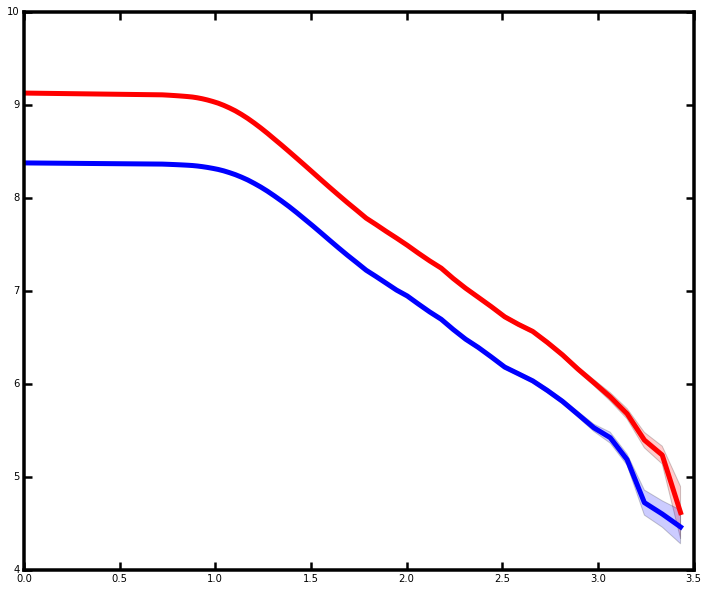

In [78]:
ax1 = plt.subplot(1,1,1)
ax1.plot(rKpcI**0.25, muI, c='r', linewidth=5)
ax1.fill_between(rKpcI**0.25, 
                 (muI + muErrI), 
                 (muI - muErrI),
                 facecolor='r', 
                 alpha=0.2)

ax1.plot(rKpcG**0.25, muG, c='b', linewidth=5)
ax1.fill_between(rKpcG**0.25, 
                 (muG + muErrG), 
                 (muG - muErrG),
                 facecolor='b', 
                 alpha=0.2)

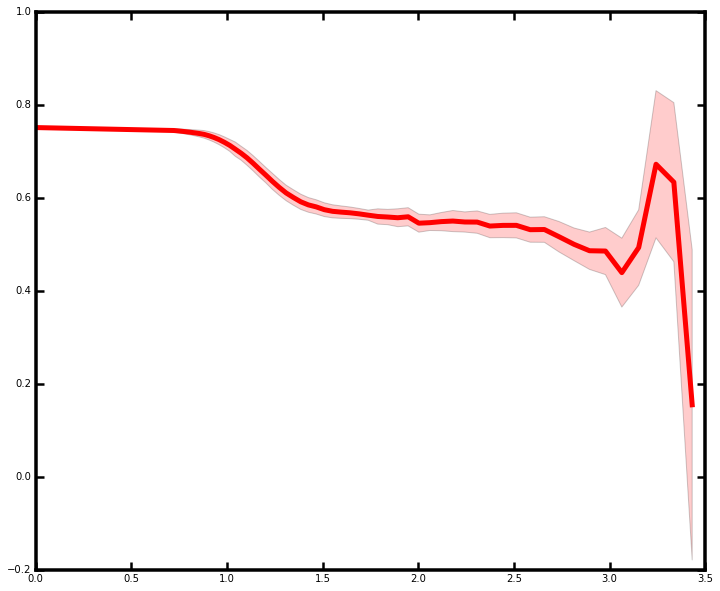

In [83]:
giColor, giErr = (muI - muG), errAdd(muErrG, muErrI)
plt.plot(rKpcG**0.25, giColor, c='r', linewidth=5)
plt.fill_between(rKpcG**0.25, 
                 (giColor + giErr), 
                 (giColor - giErr),
                 facecolor='r', 
                 alpha=0.2)

# redMapper Catalog

In [110]:
redCat1 = os.path.join(redBCG, 'hsc_redmapper_cluster_1509.fits')
redCat2 = os.path.join(redBCG, 'hsc_redmapper_cluster_1509_gamma_mass.fits')

redData1 = Table.read(redCat1, format='fits')
redData2 = Table.read(redCat2, format='fits')

In [111]:
redData1

ID_CLUSTER,NAME,RA_BCG,DEC_BCG,Z_LAMBDA,Z_LAMBDA_ERR,LAMBDA_CLUSTER,LAMBDA_ERR_CLUSTER,S_CLUSTER,Z_SPEC_BCG,OBJID_BCG,IMAG_BCG,IMAG_ERR_BCG,MODEL_MAG_u_BCG,MODEL_MAG_g_BCG,MODEL_MAG_r_BCG,MODEL_MAG_i_BCG,MODEL_MAG_z_BCG,MODEL_MAGERR_u_BCG,MODEL_MAGERR_g_BCG,MODEL_MAGERR_r_BCG,MODEL_MAGERR_i_BCG,MODEL_MAGERR_z_BCG,ILUM_BCG,PZBINS_1,PZBINS_2,PZBINS_3,PZ_1,PZ_2,PZ_3,P_CEN_1,P_CEN_2,P_CEN_3,P_CEN_4,P_CEN_5,RA_CEN_1,RA_CEN_2,RA_CEN_3,RA_CEN_4,RA_CEN_5,DEC_CEN_1,DEC_CEN_2,DEC_CEN_3,DEC_CEN_4,DEC_CEN_5,ID_CEN_1,ID_CEN_2,ID_CEN_3,ID_CEN_4,ID_CEN_5
int32,str20,float64,float64,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64,int64
33,RMJ141424.1-002239.5,213.600241851,-0.377643773856,0.137615,0.00377854,107.537,3.83507,1.00033,0.137727,1237648704053444825,14.7949,0.00296451,18.2917,16.2233,15.14,14.7192,14.3727,0.0473954,0.00464062,0.00301431,0.002966,0.00632695,78.2572,0.11652,0.11863,0.120739,2.4552e-05,0.000450303,0.0048915,0.997545,0.00244554,9.66235e-06,6.05307e-08,5.55713e-08,213.6,213.622,213.758,213.602,213.621,-0.377644,-0.37474,-0.468384,-0.384271,-0.375092,1237648704053444825,1237648704053444899,1237648720708632671,1237648704053444828,1237648704053444900
127,RMJ023141.2-045257.4,37.9215494302,-4.88262224401,0.18923,0.00452156,90.6188,3.77701,0.999921,0.185217,1237679322325713067,15.9948,0.00494084,20.03,17.7451,16.431,15.9781,15.6008,0.168792,0.00983159,0.00520637,0.00494234,0.0100368,68.466,0.162186,0.164891,0.167595,3.4648e-07,1.94369e-05,0.000525781,0.85245,0.0962763,0.0446248,0.0060264,0.000622559,37.9216,37.9037,37.9432,37.9076,37.9386,-4.88262,-4.8876,-4.88097,-4.89536,-4.84441,1237679322325713067,1237679322325713048,1237679322325713253,1237679322325713172,1237679322325713102
378,RMJ144032.0-013727.1,220.133413307,-1.62418757631,0.33355,0.014057,91.1222,4.58637,0.992496,0.322272,1237655693013090726,18.0755,0.0142381,24.2008,20.427,18.7154,18.0731,17.7614,2.27948,0.0515717,0.0172497,0.0142382,0.0319797,56.9951,0.242738,0.25182,0.260901,1.44641e-11,5.95608e-09,1.07995e-06,0.725956,0.27301,0.000673827,0.00021841,0.000141779,220.133,220.131,220.145,220.146,220.133,-1.62419,-1.62566,-1.61546,-1.61879,-1.63514,1237655693013090726,1237655499208524169,1237655693013091284,1237655693013091286,1237655499208524760
647,RMJ115610.8-002100.8,179.045048058,-0.350228462597,0.267771,0.00924858,67.4617,3.70739,1.00055,0.256297,1237674649928270001,16.0972,0.00524123,20.6709,18.0659,16.5406,16.0145,15.6979,0.388288,0.0132605,0.00588256,0.00515613,0.0126928,58.8128,0.210911,0.216597,0.222283,1.13421e-08,9.85486e-07,5.50921e-05,0.998906,0.000857584,0.000148928,8.0136e-05,7.57874e-06,179.045,179.041,179.049,179.061,179.045,-0.350228,-0.325813,-0.344623,-0.337147,-0.349433,1237674649928270001,1237674649928270017,1237674649928270184,1237674649928270224,1237674649928270002
809,RMJ021441.1-043402.5,33.6712223078,-4.5673542295,0.146935,0.00416753,57.8053,3.63009,1.03216,-1.0,1237679254134259976,14.7733,0.00338408,18.3384,16.2797,15.1651,14.7173,14.4228,0.0625208,0.0052346,0.00343827,0.00333235,0.00763607,55.3318,0.123344,0.125704,0.128063,1.59316e-05,0.000287315,0.00390038,0.979389,0.0131424,0.00723772,0.000151228,7.97547e-05,33.6712,33.6654,33.6393,33.6867,33.6735,-4.56735,-4.53104,-4.48653,-4.57705,-4.5531,1237679254134259976,1237679254134259971,1237669769764864074,1237679254134259977,1237679254134260040
889,RMJ022944.0-033653.5,37.433190043,-3.61487023934,0.327605,0.0138966,75.6384,4.57935,0.994286,-1.0,1237679323936129218,16.8923,0.0104615,20.9936,19.2498,17.4721,16.8453,16.4725,0.436413,0.0353622,0.0121055,0.0104643,0.0231379,57.7465,0.235061,0.244316,0.25357,5.34211e-12,2.27187e-09,4.89646e-07,0.997398,0.00166266,0.000379908,0.000345412,0.00021381

In [112]:
redData2

ID_CLUSTER,NAME,RA_BCG,DEC_BCG,Z_LAMBDA,Z_LAMBDA_ERR,LAMBDA_CLUSTER,LAMBDA_ERR_CLUSTER,S_CLUSTER,Z_SPEC_BCG,OBJID_BCG,IMAG_BCG,IMAG_ERR_BCG,MODEL_MAG_u_BCG,MODEL_MAG_g_BCG,MODEL_MAG_r_BCG,MODEL_MAG_i_BCG,MODEL_MAG_z_BCG,MODEL_MAGERR_u_BCG,MODEL_MAGERR_g_BCG,MODEL_MAGERR_r_BCG,MODEL_MAGERR_i_BCG,MODEL_MAGERR_z_BCG,ILUM_BCG,PZBINS_1,PZBINS_2,PZBINS_3,PZ_1,PZ_2,PZ_3,P_CEN_1,P_CEN_2,P_CEN_3,P_CEN_4,P_CEN_5,RA_CEN_1,RA_CEN_2,RA_CEN_3,RA_CEN_4,RA_CEN_5,DEC_CEN_1,DEC_CEN_2,DEC_CEN_3,DEC_CEN_4,DEC_CEN_5,ID_CEN_1,ID_CEN_2,ID_CEN_3,ID_CEN_4,ID_CEN_5,ra_hsc,dec_hsc,tract,patch,id,parent,a_g,a_r,a_i,a_z,a_y,imag_aperture01,imag_aperture02,imag_aperture03,imag_aperture04,imag_aperture05,imag_aperture06,imag_aperture07,imag_aperture08,imag_aperture09,gmag_psf,gmag_psf_err,rmag_psf,rmag_psf_err,imag_psf,imag_psf_err,zmag_psf,zmag_psf_err,ymag_psf,ymag_psf_err,gmag_kron,gmag_kron_err,rmag_kron,rmag_kron_err,imag_kron,imag_kron_err,zmag_kron,zmag_kron_err,ymag_kron,ymag_kron_err,gmag_cmodel,gmag_cmodel_err,gmag_cmodel_exp,gmag_cmodel_exp_err,gmag_cmodel_dev,gmag_cmodel_dev_err,rmag_cmodel,rmag_cmodel_err,rmag_cmodel_exp,rmag_cmodel_exp_err,rmag_cmodel_dev,rmag_cmodel_dev_err,imag_cmodel,imag_cmodel_err,imag_cmodel_exp,imag_cmodel_exp_err,imag_cmodel_dev,imag_cmodel_dev_err,zmag_cmodel,zmag_cmodel_err,zmag_cmodel_exp,zmag_cmodel_exp_err,zmag_cmodel_dev,zmag_cmodel_dev_err,ymag_cmodel,ymag_cmodel_err,ymag_cmodel_exp,ymag_cmodel_exp_err,ymag_cmodel_dev,ymag_cmodel_dev_err,if_classification_extendedness,if_flags_pixel_edge,if_flags_pixel_interpolated_center,if_flags_pixel_saturated_center,if_centroid_naive_flags,if_centroid_sdss_flags,if_flux_aperture_flags,if_flux_kron_flags,if_cmodel_flux_flags,if_shape_sdss_flags,if_countinputs,if_cmodel_fracdev,if_cmodel_objective,im_mag_kron_1,im_mag_kron_1a,im_mag_cmodel,im_mag_cmodel_err,im_mag_cmodel_exp,im_mag_cmodel_dev,im_cmodel_flux,im_cmodel_flux_err,im_cmodel_exp_flux,im_cmodel_exp_flux_err,im_cmodel_dev_flux,im_cmodel_dev_flux_err,im_deblend_blendedness,im_cmodel_exp_ixx,im_cmodel_exp_iyy,im_cmodel_exp_ixy,im_cmodel_dev_ixx,im_cmodel_dev_iyy,im_cmodel_dev_ixy,im_cmodel_fracdev,im_cmodel_objective,im_classification_extendedness,im_flux_kron_flags,im_cmodel_flux_flags,im_shape_sdss_flags,im_detect_is_patch_inner,im_detect_is_tract_inner,im_detect_is_primary,im_merge_peak_g,im_merge_peak_r,im_merge_peak_i,im_merge_peak_z,im_merge_peak_y,im_merge_footprint_g,im_merge_footprint_r,im_merge_footprint_i,im_merge_footprint_z,im_merge_footprint_y,ir_deblend_blendedness,ir_deblend_has_stray_flux,ir_deblend_masked,ir_deblend_parent_too_big,ir_deblend_skipped,ir_deblend_too_many_peaks,ir_deblend_as_psf,ir_detect_is_patch_inner,ir_detect_is_tract_inner,ir_detect_is_primary,ir_merge_measurement_g,ir_merge_measurement_r,ir_merge_measurement_i,ir_merge_measurement_z,ir_merge_measurement_y,ra_gama,dec_gama,gama_id,gama_name,n_spec,n_gama_spec,gama_specid,survey,survey_code,z_gama,z_use,zquality_gama,z_tonry_gama,zprob_gama,objid_dr6,nbands,logms_gama,logms_err_gama,logm2l_i_gama,logm2l_i_err_gama,gi_rest_sed,gi_rest_sed_err,ur_rest_sed,ur_rest_sed_err,gi_rest_star,ur_rest_star,GAL_MAG_R,GAL_RE_R,GAL_INDEX_R,GAL_ELLIP_R,GAL_PA_R,GAL_MAG_ERR_R,GAL_RE_ERR_R,GAL_ELLIP_ERR_R,GAL_PA_ERR_R,GAL_MAG_I,GAL_RE_I,GAL_INDEX_I,GAL_ELLIP_I,GAL_PA_I,GAL_MAG_ERR_I,GAL_RE_ERR_I,GAL_INDEX_ERR_I,GAL_ELLIP_ERR_I,GAL_PA_ERR_I,ra_sdss,dec_sdss,objid_dr12,specobjid_dr12,plate,mjd,fiberid,ra_fib,dec_fib,ra_err_sdss,dec_err_sdss,z_sdss,z_err_sdss,veldisp,veldisp_err,cmodelMag_u,cmodelMagErr_u,cmodelMag_g,cmodelMagErr_g,cmodelMag_r,cmodelMagErr_r,cmodelMag_i,cmodelMagErr_i,cmodelMag_z,cmodelMagErr_z,modelMag_u,modelMagErr_u,modelMag_g,modelMagErr_g,modelMag_r,modelMagErr_r,modelMag_i,modelMagErr_i,modelMag_z,modelMagErr_z,petroMag_u,petroMagErr_u,petroMag_g,petroMagErr_g,petroMag_r,petroMagErr_r,petroMag_i,petroMagErr_i,petroMag_z,petroMagErr_z,model_gr,model_gi,fracDev_r,fracDev_i,devRad_r,devRad_i,devAB_r,devAB_i,devRadErr_r,devABErr_r,expRa

# Necessary information includes:
1. ID: ID_CLUSTER
2. RA, DEC: RA_BCG, DEC_BCG 
3. Redshift: Z_LAMBDA 

In [187]:
colTemp = (np.asarray(redData2['Z_LAMBDA']) * 0.0 - 9999.0)
newRedCat = copy.deepcopy(redData2)

col1 = Column(name='ilum_max', data=colTemp)
col2 = Column(name='ilum_100', data=colTemp)
col3 = Column(name='ilum_50', data=colTemp)
col4 = Column(name='ilum_25', data=colTemp)
col5 = Column(name='ilum_10', data=colTemp)

col6 = Column(name='glum_hsc', data=colTemp)
col7 = Column(name='rlum_hsc', data=colTemp)
col8 = Column(name='ilum_hsc', data=colTemp)
col9 = Column(name='zlum_hsc', data=colTemp)
col10 = Column(name='ylum_hsc', data=colTemp)
newRedCat.add_columns([col1, col2, col3, col4, col5, 
                       col6, col7, col8, col9, col10])

In [188]:
ellRed = []

with ProgressBar(len(redData2), ipython_widget=True) as bar:
    
    for (i, galaxy) in enumerate(redData2): 
        
        """ For red BCG """
        loc = redBCG 
    
        """ ID, Z, RA, DEC """
        galID = galaxy['ID_CLUSTER']
        redshift = galaxy['Z_LAMBDA']

        """ Location and Table name """
        sumDir = os.path.join(loc, 'sum')
        sumTab = str(galID) + '_sbp_sum.fits'
        if not os.path.exists(loc): 
            os.mkdir(sumDir, exist_ok=True)
        sumTable = os.path.join(sumDir, sumTab)

        ellTab = sbpCollect(loc, galID, redshift, 
                               prefix='redBCG', save=False, 
                               a_g=galaxy['a_g'], a_r=galaxy['a_r'],
                               a_i=galaxy['a_i'], a_z=galaxy['a_z'],
                               a_y=galaxy['a_y'])
        if ellTab is not None:
            
            """ Radius KPc """
            rKpc = ellTab['rKpc']
            """ Maximum i-band luminosity """
            maxLumI1 = np.nanmax(ellTab['lumI1'])
            ellTab.meta['ILUM_MAX'] = maxLumI1.astype(np.float32)
            ellTab.meta['ILUM_100'] = np.nanmax(ellTab['lumI1'][rKpc <= 100.0])
            ellTab.meta['ILUM_50'] = np.nanmax(ellTab['lumI1'][rKpc <= 50.0])
            ellTab.meta['ILUM_25'] = np.nanmax(ellTab['lumI1'][rKpc <= 25.0])
            ellTab.meta['ILUM_10'] = np.nanmax(ellTab['lumI1'][rKpc <= 10.0])

            """ Update the metadata """
            ellTab.meta['RA'] = galaxy['RA_BCG'].astype(np.float32)
            ellTab.meta['DEC'] = galaxy['DEC_BCG'].astype(np.float32)
    
            """ STELLAR MASS FROM OTHER WORKS """
            if np.isfinite(galaxy['logms_gama'].astype(np.float32)):
                ellTab.meta['LOGM1'] = galaxy['logms_gama'].astype(np.float32)
            else: 
                ellTab.meta['LOGM1'] = -9999.0
                
            if np.isfinite(galaxy['logms_err_gama'].astype(np.float32)):
                ellTab.meta['LOGM1E'] = galaxy['logms_err_gama'].astype(np.float32)
            else: 
                ellTab.meta['LOGM1E'] = -9999.0
    
            """ STELLAR MASS FROM ISEDFIT """
            ellTab.meta['LOGM2'] = galaxy['MSTAR'].astype(np.float32)
            ellTab.meta['LOGM2E'] = galaxy['MSTAR_ERR'].astype(np.float32)
    
            """ HSC CMODEL MAG (EXTINCTION CORRECTED) """
            gmag_hsc = (galaxy['gmag_cmodel'] - galaxy['a_g']).astype(np.float32)
            rmag_hsc = (galaxy['rmag_cmodel'] - galaxy['a_r']).astype(np.float32)
            imag_hsc = (galaxy['imag_cmodel'] - galaxy['a_i']).astype(np.float32)
            zmag_hsc = (galaxy['zmag_cmodel'] - galaxy['a_z']).astype(np.float32)
            ymag_hsc = (galaxy['ymag_cmodel'] - galaxy['a_y']).astype(np.float32)
        
            ellTab.meta['GCMOD_HSC'] = gmag_hsc
            ellTab.meta['RCMOD_HSC'] = rmag_hsc
            ellTab.meta['ICMOD_HSC'] = imag_hsc
            ellTab.meta['ZCMOD_HSC'] = zmag_hsc
            ellTab.meta['YCMOD_HSC'] = ymag_hsc
            
            glum_hsc = getLumimosity(gmag_hsc, redshift, amag_sun=amag_sun_des_g)
            rlum_hsc = getLumimosity(rmag_hsc, redshift, amag_sun=amag_sun_des_r)
            ilum_hsc = getLumimosity(imag_hsc, redshift, amag_sun=amag_sun_des_i)
            zlum_hsc = getLumimosity(zmag_hsc, redshift, amag_sun=amag_sun_des_z)
            ylum_hsc = getLumimosity(ymag_hsc, redshift, amag_sun=amag_sun_des_y)

            """ HSC CMODEL LUMINOSITY """
            ellTab.meta['GLUM_HSC'] = glum_hsc
            ellTab.meta['RLUM_HSC'] = rlum_hsc
            ellTab.meta['ILUM_HSC'] = ilum_hsc
            ellTab.meta['ZLUM_HSC'] = zlum_hsc
            ellTab.meta['YLUM_HSC'] = ylum_hsc
            
            ellTab.write(sumTable, format='fits', overwrite=True)
            
            ## Pass it to table 
            newRedCat['ilum_max'][i] = ellTab.meta['ILUM_MAX']
            newRedCat['ilum_100'][i] = ellTab.meta['ILUM_100']
            newRedCat['ilum_50'][i] = ellTab.meta['ILUM_50']
            newRedCat['ilum_25'][i] = ellTab.meta['ILUM_25']
            newRedCat['ilum_10'][i] = ellTab.meta['ILUM_10']
            newRedCat['glum_hsc'][i] = glum_hsc
            newRedCat['rlum_hsc'][i] = rlum_hsc
            newRedCat['ilum_hsc'][i] = ilum_hsc
            newRedCat['zlum_hsc'][i] = zlum_hsc
            newRedCat['ylum_hsc'][i] = ylum_hsc
            
            """"""
            ellRed.append(ellTab)
        else: 
            warnings.warn('### NO USEFUL DATA FOR %i' % galID)
            
        bar.update()
               
# Save a new table 
newRedCat.write(os.path.join(redBCG, 'redBCG_new.fits'), format='fits', 
                overwrite=True)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:49: UserWarning: ### Can not find the smallR1 for I-band!
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:116: UserWarning: ### Model is not available at /Users/songhuang/astro3/hscs/redmapper for 5197
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:100: UserWarning: ### NO USEFUL DATA FOR 5197
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:116: UserWarning: ### Model is not available at /Users/songhuang/astro3/hscs/redmapper for 15947
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:100: UserWarning: ### NO USEFUL DATA FOR 15947
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:116: UserWarning: ### Model is not available at /Users/songhuang/astro3/hscs/redmapper for 16054
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:100: UserWarnin

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:100: UserWarning: ### NO USEFUL DATA FOR 48732


# GAMA non-BCG Catalog 

In [113]:
gamaCat = os.path.join(nonBCG, 'massive_nonBCG_test.fits')

gamaData = Table.read(gamaCat, format='fits')

In [114]:
gamaData

ISEDFIT_ID,RA,DEC,Z,MAGGIES [5],IVARMAGGIES [5],BESTMAGGIES [5],CHUNKINDX,MODELINDX,DELAYED,BURSTTYPE,CHI2,TOTALMASS,TOTALMASS_ERR,MSTAR,AGE,SFRAGE,TAU,ZMETAL,AV,MU,OIIIHB,NLYC,SFR,SFR100,B100,B1000,EWOII,EWOIIIHB,EWNIIHA,NBURST,TRUNCTAU,TBURST [5],DTBURST [5],FBURST [5],MSTAR_50,AGE_50,SFRAGE_50,TAU_50,ZMETAL_50,AV_50,MU_50,OIIIHB_50,SFR_50,SFR100_50,B100_50,B1000_50,EWOII_50,EWOIIIHB_50,EWNIIHA_50,MSTAR_AVG,AGE_AVG,SFRAGE_AVG,TAU_AVG,ZMETAL_AVG,AV_AVG,MU_AVG,OIIIHB_AVG,SFR_AVG,SFR100_AVG,B100_AVG,B1000_AVG,EWOII_AVG,EWOIIIHB_AVG,EWNIIHA_AVG,MSTAR_ERR,AGE_ERR,SFRAGE_ERR,TAU_ERR,ZMETAL_ERR,AV_ERR,MU_ERR,OIIIHB_ERR,SFR_ERR,SFR100_ERR,B100_ERR,B1000_ERR,EWOII_ERR,EWOIIIHB_ERR,EWNIIHA_ERR,ra_hsc,dec_hsc,tract,patch,id,parent,a_g,a_r,a_i,a_z,a_y,imag_aperture01,imag_aperture02,imag_aperture03,imag_aperture04,imag_aperture05,imag_aperture06,imag_aperture07,imag_aperture08,imag_aperture09,gmag_psf,gmag_psf_err,rmag_psf,rmag_psf_err,imag_psf,imag_psf_err,zmag_psf,zmag_psf_err,ymag_psf,ymag_psf_err,gmag_kron,gmag_kron_err,rmag_kron,rmag_kron_err,imag_kron,imag_kron_err,zmag_kron,zmag_kron_err,ymag_kron,ymag_kron_err,gmag_cmodel,gmag_cmodel_err,gmag_cmodel_exp,gmag_cmodel_exp_err,gmag_cmodel_dev,gmag_cmodel_dev_err,rmag_cmodel,rmag_cmodel_err,rmag_cmodel_exp,rmag_cmodel_exp_err,rmag_cmodel_dev,rmag_cmodel_dev_err,imag_cmodel,imag_cmodel_err,imag_cmodel_exp,imag_cmodel_exp_err,imag_cmodel_dev,imag_cmodel_dev_err,zmag_cmodel,zmag_cmodel_err,zmag_cmodel_exp,zmag_cmodel_exp_err,zmag_cmodel_dev,zmag_cmodel_dev_err,ymag_cmodel,ymag_cmodel_err,ymag_cmodel_exp,ymag_cmodel_exp_err,ymag_cmodel_dev,ymag_cmodel_dev_err,if_classification_extendedness,if_flags_pixel_edge,if_flags_pixel_interpolated_center,if_flags_pixel_saturated_center,if_centroid_naive_flags,if_centroid_sdss_flags,if_flux_aperture_flags,if_flux_kron_flags,if_cmodel_flux_flags,if_shape_sdss_flags,if_countinputs,if_cmodel_fracdev,if_cmodel_objective,im_mag_kron_1,im_mag_kron_1a,im_mag_cmodel,im_mag_cmodel_err,im_mag_cmodel_exp,im_mag_cmodel_dev,im_cmodel_flux,im_cmodel_flux_err,im_cmodel_exp_flux,im_cmodel_exp_flux_err,im_cmodel_dev_flux,im_cmodel_dev_flux_err,im_deblend_blendedness,im_cmodel_exp_ixx,im_cmodel_exp_iyy,im_cmodel_exp_ixy,im_cmodel_dev_ixx,im_cmodel_dev_iyy,im_cmodel_dev_ixy,im_cmodel_fracdev,im_cmodel_objective,im_classification_extendedness,im_flux_kron_flags,im_cmodel_flux_flags,im_shape_sdss_flags,im_detect_is_patch_inner,im_detect_is_tract_inner,im_detect_is_primary,im_merge_peak_g,im_merge_peak_r,im_merge_peak_i,im_merge_peak_z,im_merge_peak_y,im_merge_footprint_g,im_merge_footprint_r,im_merge_footprint_i,im_merge_footprint_z,im_merge_footprint_y,ir_deblend_blendedness,ir_deblend_has_stray_flux,ir_deblend_masked,ir_deblend_parent_too_big,ir_deblend_skipped,ir_deblend_too_many_peaks,ir_deblend_as_psf,ir_detect_is_patch_inner,ir_detect_is_tract_inner,ir_detect_is_primary,ir_merge_measurement_g,ir_merge_measurement_r,ir_merge_measurement_i,ir_merge_measurement_z,ir_merge_measurement_y,ra_gama,dec_gama,gama_id,gama_name,n_spec,n_gama_spec,gama_specid,survey,survey_code,z_gama,z_use,zquality_gama,z_tonry_gama,zprob_gama,objid_dr6,nbands,logms_gama,logms_err_gama,logm2l_i_gama,logm2l_i_err_gama,fluxscale_gama,gi_rest_sed,gi_rest_sed_err,ur_rest_sed,ur_rest_sed_err,gi_rest_star,ur_rest_star,GAL_MAG_R,GAL_RE_R,GAL_INDEX_R,GAL_ELLIP_R,GAL_PA_R,GAL_MAG_ERR_R,GAL_RE_ERR_R,GAL_ELLIP_ERR_R,GAL_PA_ERR_R,GAL_MAG_I,GAL_RE_I,GAL_INDEX_I,GAL_ELLIP_I,GAL_PA_I,GAL_MAG_ERR_I,GAL_RE_ERR_I,GAL_INDEX_ERR_I,GAL_ELLIP_ERR_I,GAL_PA_ERR_I,ra_sdss,dec_sdss,objid_dr12,specobjid_dr12,plate,mjd,fiberid,ra_fib,dec_fib,ra_err_sdss,dec_err_sdss,z_sdss,z_err_sdss,veldisp,veldisp_err,cmodelMag_u,cmodelMagErr_u,cmodelMag_g,cmodelMagErr_g,cmodelMag_r,cmodelMagErr_r,cmodelMag_i,cmodelMagErr_i,cmodelMag_z,cmodelMagErr_z,modelMag_u,modelMagErr_u,modelMag_g,modelMagErr_g,modelMag_r,modelMagErr_r,modelMag_i,modelMagErr_i,modelMag_z,modelMagErr_z,petroMag_u,petroMagErr_u,petroMag_g,petroMagErr_g,petroMag_r,

In [189]:
colTemp = (np.asarray(gamaData['MSTAR']) * 0.0 - 9999.0)
newGamaCat = copy.deepcopy(gamaData)

col1 = Column(name='ilum_max', data=colTemp)
col2 = Column(name='ilum_100', data=colTemp)
col3 = Column(name='ilum_50', data=colTemp)
col4 = Column(name='ilum_25', data=colTemp)
col5 = Column(name='ilum_10', data=colTemp)

col6 = Column(name='glum_hsc', data=colTemp)
col7 = Column(name='rlum_hsc', data=colTemp)
col8 = Column(name='ilum_hsc', data=colTemp)
col9 = Column(name='zlum_hsc', data=colTemp)
col10 = Column(name='ylum_hsc', data=colTemp)
newGamaCat.add_columns([col1, col2, col3, col4, col5, 
                       col6, col7, col8, col9, col10])

In [191]:
ellGama = []

with ProgressBar(len(gamaData), ipython_widget=True) as bar:
    
    for (i, galaxy) in enumerate(gamaData): 
        
        """ For non BCG """
        loc = nonBCG 
    
        """ ID, Z, RA, DEC """
        galID = galaxy['ISEDFIT_ID']
        redshift = galaxy['Z']

        """ Location and Table name """
        sumDir = os.path.join(loc, 'sum')
        sumTab = str(galID) + '_sbp_sum.fits'
        if not os.path.exists(loc): 
            os.mkdir(sumDir, exist_ok=True)
        sumTable = os.path.join(sumDir, sumTab)

        ellTab = sbpCollect(loc, galID, redshift, 
                               prefix='nonBCG', save=False, 
                               a_g=galaxy['a_g'], a_r=galaxy['a_r'],
                               a_i=galaxy['a_i'], a_z=galaxy['a_z'],
                               a_y=galaxy['a_y'])
        if ellTab is not None:
        
            """ Radius KPc """
            rKpc = ellTab['rKpc']
            """ Maximum i-band luminosity """
            maxLumI1 = np.nanmax(ellTab['lumI1'])
            ellTab.meta['ILUM_MAX'] = maxLumI1.astype(np.float32)
            ellTab.meta['ILUM_100'] = np.nanmax(ellTab['lumI1'][rKpc <= 100.0])
            ellTab.meta['ILUM_50'] = np.nanmax(ellTab['lumI1'][rKpc <= 50.0])
            ellTab.meta['ILUM_25'] = np.nanmax(ellTab['lumI1'][rKpc <= 25.0])
            ellTab.meta['ILUM_10'] = np.nanmax(ellTab['lumI1'][rKpc <= 10.0])

            """ Update the metadata """
            ellTab.meta['RA'] = galaxy['RA'].astype(np.float32)
            ellTab.meta['DEC'] = galaxy['DEC'].astype(np.float32)
    
            """ STELLAR MASS FROM OTHER WORKS """
            if np.isfinite(galaxy['logms_gama'].astype(np.float32)):
                ellTab.meta['LOGM1'] = galaxy['logms_gama'].astype(np.float32)
            else: 
                ellTab.meta['LOGM1'] = -9999.0
                
            if np.isfinite(galaxy['logms_err_gama'].astype(np.float32)):
                ellTab.meta['LOGM1E'] = galaxy['logms_err_gama'].astype(np.float32)
            else: 
                ellTab.meta['LOGM1E'] = -9999.0
    
            """ STELLAR MASS FROM ISEDFIT """
            ellTab.meta['LOGM2'] = galaxy['MSTAR'].astype(np.float32)
            ellTab.meta['LOGM2E'] = galaxy['MSTAR_ERR'].astype(np.float32)
    
            """ HSC CMODEL MAG (EXTINCTION CORRECTED) """
            gmag_hsc = (galaxy['gmag_cmodel'] - galaxy['a_g']).astype(np.float32)
            rmag_hsc = (galaxy['rmag_cmodel'] - galaxy['a_r']).astype(np.float32)
            imag_hsc = (galaxy['imag_cmodel'] - galaxy['a_i']).astype(np.float32)
            zmag_hsc = (galaxy['zmag_cmodel'] - galaxy['a_z']).astype(np.float32)
            ymag_hsc = (galaxy['ymag_cmodel'] - galaxy['a_y']).astype(np.float32)
        
            ellTab.meta['GCMOD_HSC'] = gmag_hsc
            ellTab.meta['RCMOD_HSC'] = rmag_hsc
            ellTab.meta['ICMOD_HSC'] = imag_hsc
            ellTab.meta['ZCMOD_HSC'] = zmag_hsc
            ellTab.meta['YCMOD_HSC'] = ymag_hsc
            
            glum_hsc = getLumimosity(gmag_hsc, redshift, amag_sun=amag_sun_des_g)
            rlum_hsc = getLumimosity(rmag_hsc, redshift, amag_sun=amag_sun_des_r)
            ilum_hsc = getLumimosity(imag_hsc, redshift, amag_sun=amag_sun_des_i)
            zlum_hsc = getLumimosity(zmag_hsc, redshift, amag_sun=amag_sun_des_z)
            ylum_hsc = getLumimosity(ymag_hsc, redshift, amag_sun=amag_sun_des_y)

            """ HSC CMODEL LUMINOSITY """
            ellTab.meta['GLUM_HSC'] = glum_hsc
            ellTab.meta['RLUM_HSC'] = rlum_hsc
            ellTab.meta['ILUM_HSC'] = ilum_hsc
            ellTab.meta['ZLUM_HSC'] = zlum_hsc
            ellTab.meta['YLUM_HSC'] = ylum_hsc
            
            ellTab.write(sumTable, format='fits', overwrite=True)
            
            ## Pass it to table 
            newGamaCat['ilum_max'][i] = ellTab.meta['ILUM_MAX']
            newGamaCat['ilum_100'][i] = ellTab.meta['ILUM_100']
            newGamaCat['ilum_50'][i] = ellTab.meta['ILUM_50']
            newGamaCat['ilum_25'][i] = ellTab.meta['ILUM_25']
            newGamaCat['ilum_10'][i] = ellTab.meta['ILUM_10']
            newGamaCat['glum_hsc'][i] = glum_hsc
            newGamaCat['rlum_hsc'][i] = rlum_hsc
            newGamaCat['ilum_hsc'][i] = ilum_hsc
            newGamaCat['zlum_hsc'][i] = zlum_hsc
            newGamaCat['ylum_hsc'][i] = ylum_hsc
            
            """"""
            ellGama.append(ellTab)
        else: 
            warnings.warn('### NO USEFUL DATA FOR %i' % galID)
            
        bar.update()
               
# Save a new table 
newGamaCat.write(os.path.join(nonBCG, 'nonBCG_new.fits'), format='fits', 
                overwrite=True)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:49: UserWarning: ### Can not find the smallR1 for I-band!
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:89: UserWarning: ### Can not find the default for Y-band!
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:116: UserWarning: ### Model is not available at /Users/songhuang/astro3/hscs/nonbcg for 5875
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:100: UserWarning: ### NO USEFUL DATA FOR 5875
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:116: UserWarning: ### Model is not available at /Users/songhuang/astro3/hscs/nonbcg for 5755
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:100: UserWarning: ### NO USEFUL DATA FOR 5755
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:116: UserWarning: ### Model is not available at /Users/songhua

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:100: UserWarning: ### NO USEFUL DATA FOR 5675


# Photometric Comparison

In [180]:
redLogM2L = (newRedCat['MSTAR'] - newRedCat['ilum_hsc'])
gamaLogM2L = (newGamaCat['MSTAR'] - newGamaCat['ilum_hsc'])

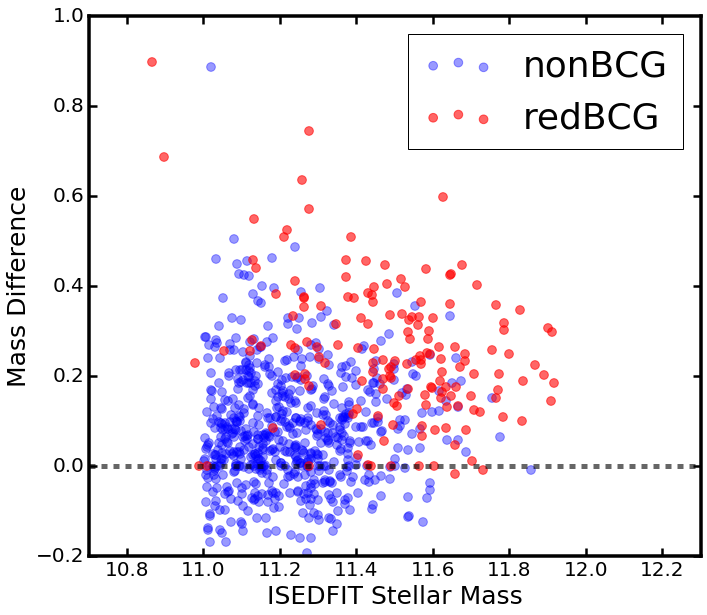

In [216]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

logmRange = np.arange(10.0, 12.5, 0.2)
ax1.plot(logmRange, logmRange, 'k', linestyle='--', linewidth=3.0, alpha=0.8)


ax1.axhline(0.0, linewidth=5.0, alpha=0.6, 
            linestyle='dashed', c='k')


# GAMA 
ax1.scatter(newGamaCat['MSTAR'], 
            (newGamaCat['ilum_max'] + gamaLogM2L) - newGamaCat['MSTAR'], 
            marker='o', color='b', s=75, label='nonBCG',
            alpha=0.4)
# Red
ax1.scatter(newRedCat['MSTAR'], 
            (newRedCat['ilum_max'] + redLogM2L) - newRedCat['MSTAR'], 
            marker='o', color='r', s=75, label='redBCG',
            alpha=0.6)

ax1.set_xlim(10.7, 12.3)
ax1.set_ylim(-0.2, 1.0)

ax1.set_xlabel('ISEDFIT Stellar Mass',  size=25.0)
ax1.set_ylabel('Mass Difference', size=25.0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

ax1.legend(prop={'size':36})

#ax1.text(-23.45, -23.0, '$0.3<z<0.4$', size=32.0)
#ax1.text(-23.25, -22.8, 'log $(M_{s}/M_{\odot})>11.6$', size=32.0)

#ax1.text(-23.35, -22.55, 'within 50 Kpc', color='g', size=32.0)
#ax1.text(-23.30, -22.35, 'within 100 Kpc', color='r', size=32.0)

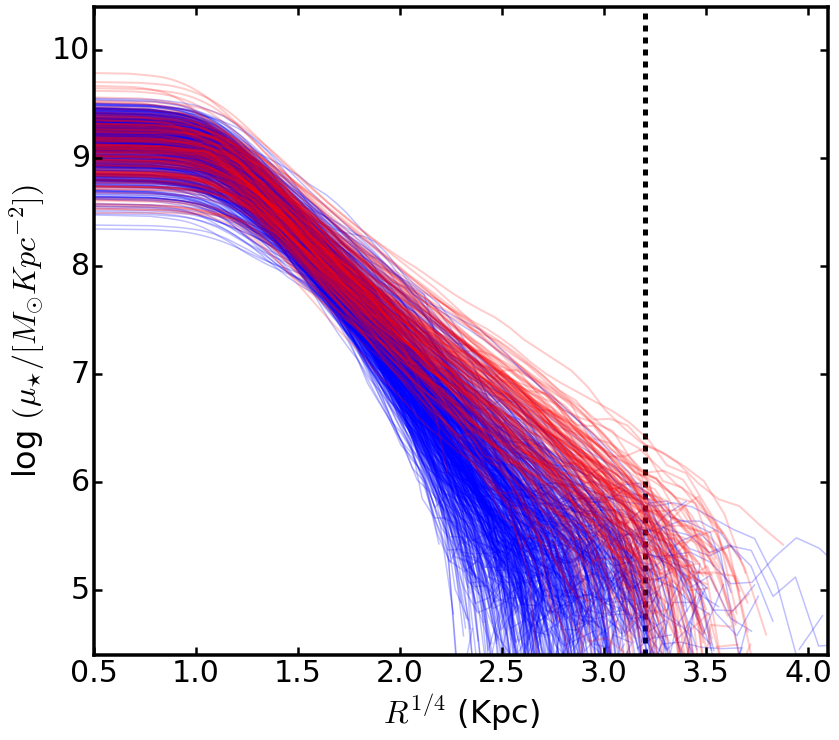

In [228]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.axvline(3.20, linewidth=5.0, c='k', linestyle='dashed')

for gamaProf in ellGama:
    m2l = (gamaProf.meta['LOGM2'] - gamaProf.meta['ILUM_HSC'])
    ax1.plot((gamaProf['rKpc']**0.25), gamaProf['muI1'] + m2l, c='b', 
             alpha=0.25, linewidth=1.5)
    
for redProf in ellRed:
    m2l = (redProf.meta['LOGM2'] - redProf.meta['ILUM_HSC'])
    ax1.plot((redProf['rKpc']**0.25), redProf['muI1'] + m2l, c='r', 
             alpha=0.2, linewidth=2.0)

#ax1.fill_between(rsma_common_z1, asbp_avg_z1+std_stack_z1, asbp_avg_z1-std_stack_z1,
#                 facecolor='b', alpha=0.2)

#ax1.text(2.4, 8.6, '$0.15<z<0.30$', size=42)

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=32)
ax1.set_ylabel('log $({\mu}_{\star}/[M_{\odot} Kpc^{-2}])$', size=32)

ax1.set_xlim(0.5, 4.1)
ax1.set_ylim(4.4, 10.4)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

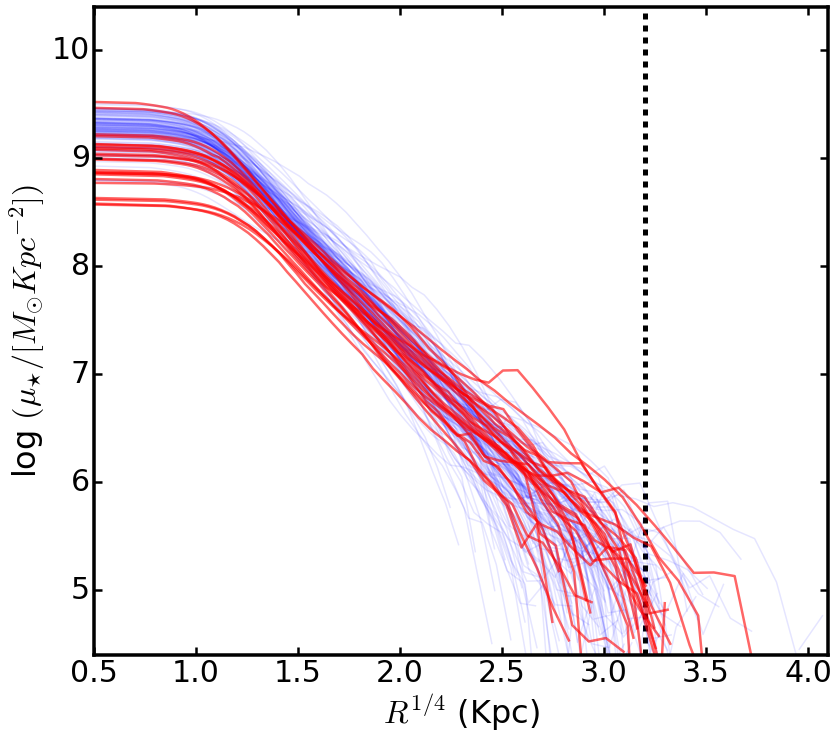

In [227]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.axvline(3.20, linewidth=5.0, c='k', linestyle='dashed')

for gamaProf in ellGama:
    m2l = (gamaProf.meta['LOGM2'] - gamaProf.meta['ILUM_HSC'])
    mnew = (gamaProf.meta['ILUM_MAX'] + m2l)
    if (mnew <= 11.6) and (mnew >= 11.40):
        ax1.plot((gamaProf['rKpc']**0.25), (gamaProf['muI1'] + m2l), c='b', 
                 alpha=0.1, linewidth=1.5)
    
for redProf in ellRed:
    m2l = (redProf.meta['LOGM2'] - redProf.meta['ILUM_HSC'])
    mnew = (redProf.meta['ILUM_MAX'] + m2l)
    redshift = redProf.meta['redshift']
    if (mnew <= 11.60) and (mnew >= 11.40):
        ax1.plot((redProf['rKpc']**0.25), redProf['muI1'] + m2l, c='r', 
                 alpha=0.6, linewidth=2.5)

#ax1.fill_between(rsma_common_z1, asbp_avg_z1+std_stack_z1, asbp_avg_z1-std_stack_z1,
#                 facecolor='b', alpha=0.2)

#ax1.text(2.4, 8.6, '$0.15<z<0.30$', size=42)

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=32)
ax1.set_ylabel('log $({\mu}_{\star}/[M_{\odot} Kpc^{-2}])$', size=32)

ax1.set_xlim(0.5, 4.1)
ax1.set_ylim(4.4, 10.4)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

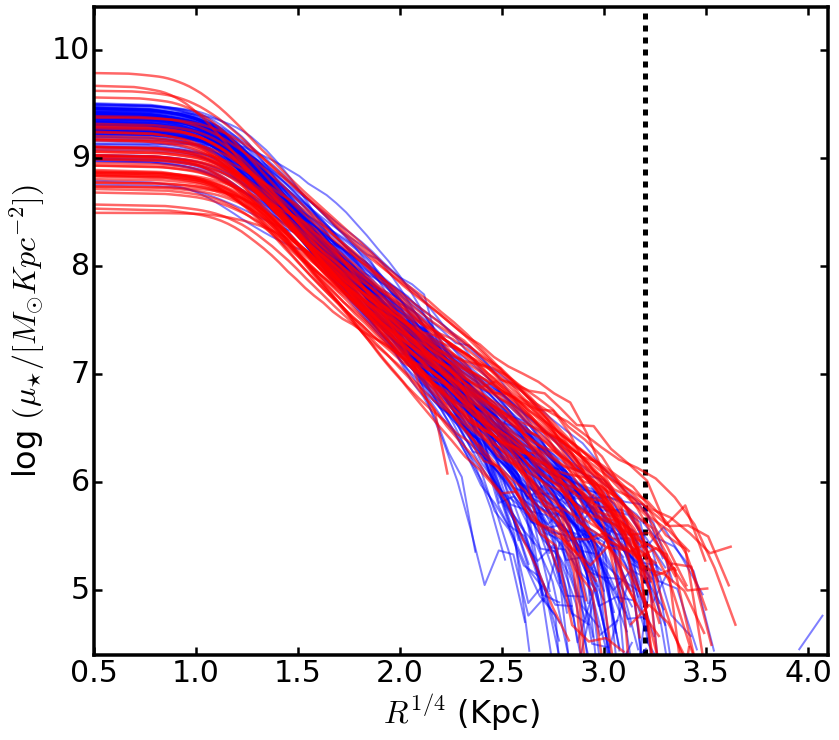

In [239]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.axvline(3.20, linewidth=5.0, c='k', linestyle='dashed')

for gamaProf in ellGama:
    m2l = (gamaProf.meta['LOGM2'] - gamaProf.meta['ILUM_HSC'])
    mnew = (gamaProf.meta['ILUM_25'] + m2l)
    if (mnew <= 11.5) and (mnew >= 11.30):
        ax1.plot((gamaProf['rKpc']**0.25), (gamaProf['muI1'] + m2l), c='b', 
                 alpha=0.5, linewidth=2.0)
    
for redProf in ellRed:
    m2l = (redProf.meta['LOGM2'] - redProf.meta['ILUM_HSC'])
    mnew = (redProf.meta['ILUM_25'] + m2l)
    redshift = redProf.meta['redshift']
    if (mnew <= 11.5) and (mnew >= 11.30):
        ax1.plot((redProf['rKpc']**0.25), redProf['muI1'] + m2l, c='r', 
                 alpha=0.6, linewidth=2.5)

#ax1.fill_between(rsma_common_z1, asbp_avg_z1+std_stack_z1, asbp_avg_z1-std_stack_z1,
#                 facecolor='b', alpha=0.2)

#ax1.text(2.4, 8.6, '$0.15<z<0.30$', size=42)

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=32)
ax1.set_ylabel('log $({\mu}_{\star}/[M_{\odot} Kpc^{-2}])$', size=32)

ax1.set_xlim(0.5, 4.1)
ax1.set_ylim(4.4, 10.4)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

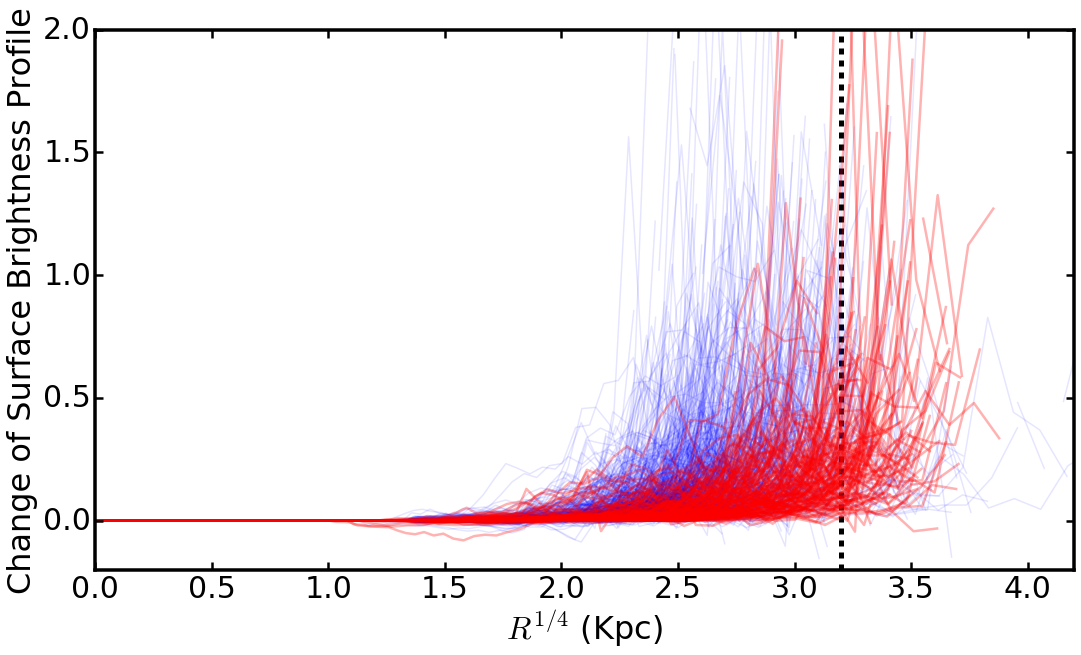

In [234]:
fig = plt.figure(figsize=(16, 10))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.axvline(3.20, linewidth=5.0, c='k', linestyle='dashed')

for gamaProf in ellGama:
    ax1.plot((gamaProf['rKpc']**0.25), gamaProf['muI2'] - gamaProf['muI1'] , c='b', 
             alpha=0.1, linewidth=1.5)
    
for redProf in ellRed:
    ax1.plot((redProf['rKpc']**0.25), redProf['muI2'] - redProf['muI1'], c='r', 
             alpha=0.3, linewidth=2.5)

#ax1.fill_between(rsma_common_z1, asbp_avg_z1+std_stack_z1, asbp_avg_z1-std_stack_z1,
#                 facecolor='b', alpha=0.2)

#ax1.text(2.4, 8.6, '$0.15<z<0.30$', size=42)

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=32)
ax1.set_ylabel('Change of Surface Brightness Profile', size=32)

ax1.set_xlim(0.0, 4.2)
ax1.set_ylim(-0.2, 2.0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

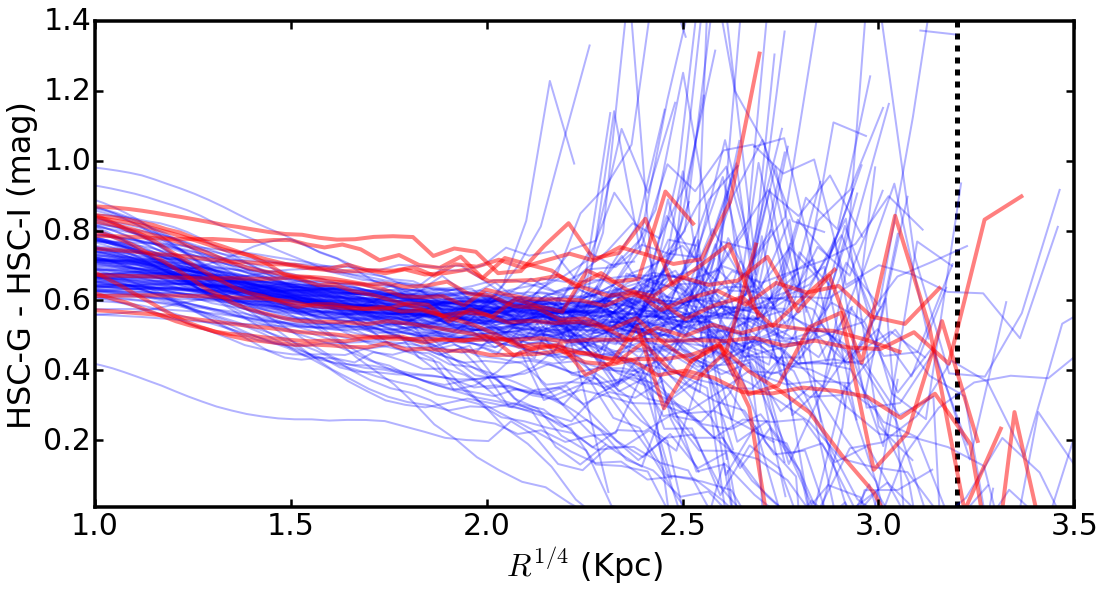

In [242]:
fig = plt.figure(figsize=(16, 9))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.axvline(3.20, linewidth=5.0, c='k', linestyle='dashed')

for gamaProf in ellGama:
    m2l = (gamaProf.meta['LOGM2'] - gamaProf.meta['ILUM_HSC'])
    mnew = (gamaProf.meta['ILUM_MAX'] + m2l)
    if (mnew <= 11.6) and (mnew >= 11.40):
        ax1.plot((gamaProf['rKpc']**0.25), (gamaProf['muZ1'] - gamaProf['muG1']), c='b', 
                 alpha=0.3, linewidth=2.0)
    
for redProf in ellRed:
    m2l = (redProf.meta['LOGM2'] - redProf.meta['ILUM_HSC'])
    mnew = (redProf.meta['ILUM_MAX'] + m2l)
    redshift = redProf.meta['redshift']
    if (mnew <= 11.6) and (mnew >= 11.40) and (redshift < 0.35):
        ax1.plot((redProf['rKpc']**0.25), (redProf['muZ1'] - redProf['muG1']), c='r', 
                 alpha=0.5, linewidth=4)

#ax1.fill_between(rsma_common_z1, asbp_avg_z1+std_stack_z1, asbp_avg_z1-std_stack_z1,
#                 facecolor='b', alpha=0.2)

#ax1.text(2.4, 8.6, '$0.15<z<0.30$', size=42)

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=32)
ax1.set_ylabel('HSC-G - HSC-I (mag)', size=32)

ax1.set_xlim(1.0, 3.5)
ax1.set_ylim(0.01, 1.4)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

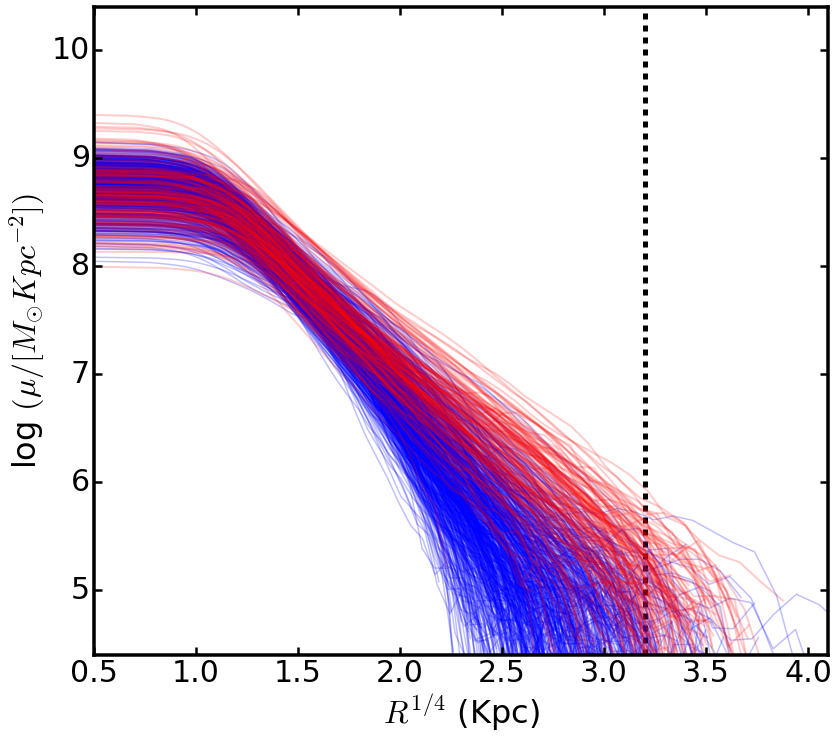

In [240]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.axvline(3.20, linewidth=5.0, c='k', linestyle='dashed')

for gamaProf in ellGama:
    ax1.plot((gamaProf['rKpc']**0.25), gamaProf['muI1'], c='b', 
             alpha=0.25, linewidth=1.5)
    
for redProf in ellRed:
    ax1.plot((redProf['rKpc']**0.25), redProf['muI1'], c='r', 
             alpha=0.2, linewidth=2.0)

#ax1.fill_between(rsma_common_z1, asbp_avg_z1+std_stack_z1, asbp_avg_z1-std_stack_z1,
#                 facecolor='b', alpha=0.2)

#ax1.text(2.4, 8.6, '$0.15<z<0.30$', size=42)

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=32)
ax1.set_ylabel('log $({\mu}/[M_{\odot} Kpc^{-2}])$', size=32)

ax1.set_xlim(0.5, 4.1)
ax1.set_ylim(4.4, 10.4)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

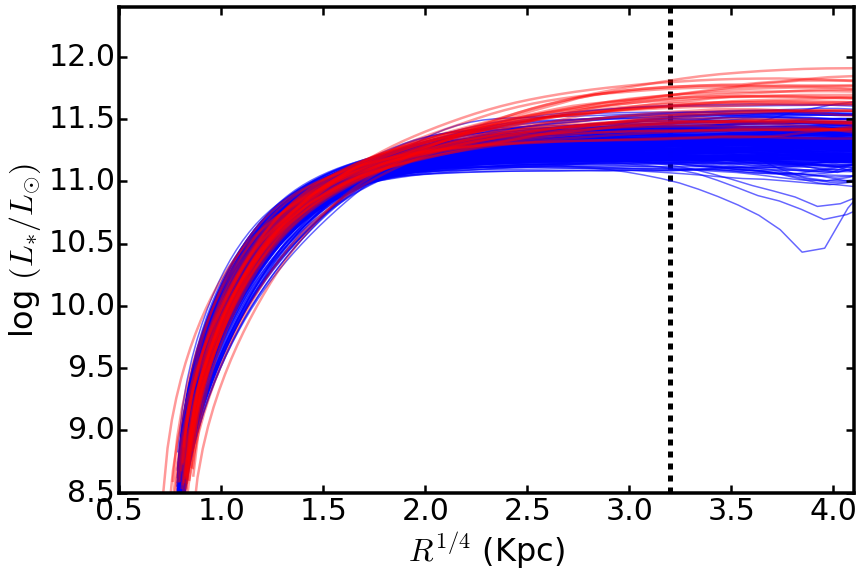

In [255]:
fig = plt.figure(figsize=(12, 9))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.axvline(3.20, linewidth=5.0, c='k', linestyle='dashed')

for gamaProf in ellGama:
    m2l = (gamaProf.meta['LOGM2'] - gamaProf.meta['ILUM_HSC'])
    mnew = (gamaProf.meta['ILUM_10'] + m2l)
    if (mnew <= 11.20) and (mnew >= 11.00):
        ax1.plot((gamaProf['rKpc']**0.25), gamaProf['lumI1'] + m2l, c='b', 
                 alpha=0.6, linewidth=1.5)
    
for redProf in ellRed:
    m2l = (redProf.meta['LOGM2'] - redProf.meta['ILUM_HSC'])
    mnew = (redProf.meta['ILUM_10'] + m2l)
    redshift = redProf.meta['redshift']
    if (mnew <= 11.20) and (mnew >= 11.00) and (redshift <= 0.40):
        ax1.plot((redProf['rKpc']**0.25), redProf['lumI1'] + m2l, c='r', 
                 alpha=0.4, linewidth=2.5)

#ax1.fill_between(rsma_common_z1, asbp_avg_z1+std_stack_z1, asbp_avg_z1-std_stack_z1,
#                 facecolor='b', alpha=0.2)

#ax1.text(2.4, 8.6, '$0.15<z<0.30$', size=42)

ax1.set_xlabel('$R^{1/4}$ (Kpc)', size=32)
ax1.set_ylabel('log $(L_{*}/L_{\odot})$', size=32)

ax1.set_xlim(0.5, 4.1)
ax1.set_ylim(8.5, 12.4)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)